<a href="https://colab.research.google.com/github/ksairos/tf-advanced-techniques-course/blob/main/course_4/C4_W1_Assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Style Transfer of a Dog Image

## Imports

In [1]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

import tensorflow as tf

import matplotlib.pyplot as plt
import numpy as np
from keras import backend as K

from imageio import mimsave
from IPython.display import display as display_fn
from IPython.display import Image, clear_output

## Utilities

In [2]:
def tensor_to_image(tensor):
  '''converts a tensor to an image'''
  tensor_shape = tf.shape(tensor)
  number_elem_shape = tf.shape(tensor_shape)
  if number_elem_shape > 3:
    assert tensor_shape[0] == 1
    tensor = tensor[0]
  return tf.keras.preprocessing.image.array_to_img(tensor) 


def load_img(path_to_img):
  '''loads an image as a tensor and scales it to 512 pixels'''
  max_dim = 512
  image = tf.io.read_file(path_to_img)
  image = tf.image.decode_jpeg(image)
  image = tf.image.convert_image_dtype(image, tf.float32)

  shape = tf.shape(image)[:-1]
  shape = tf.cast(tf.shape(image)[:-1], tf.float32)
  long_dim = max(shape)
  scale = max_dim / long_dim

  new_shape = tf.cast(shape * scale, tf.int32)

  image = tf.image.resize(image, new_shape)
  image = image[tf.newaxis, :]
  image = tf.image.convert_image_dtype(image, tf.uint8)

  return image


def load_images(content_path, style_path):
  '''loads the content and path images as tensors'''
  content_image = load_img("{}".format(content_path))
  style_image = load_img("{}".format(style_path))

  return content_image, style_image


def imshow(image, title=None):
  '''displays an image with a corresponding title'''
  if len(image.shape) > 3:
    image = tf.squeeze(image, axis=0)

  plt.imshow(image)
  if title:
    plt.title(title)
    
    
def show_images_with_objects(images, titles=[]):
  '''displays a row of images with corresponding titles'''
  if len(images) != len(titles):
    return

  plt.figure(figsize=(20, 12))
  for idx, (image, title) in enumerate(zip(images, titles)):
    plt.subplot(1, len(images), idx + 1)
    plt.xticks([])
    plt.yticks([])
    imshow(image, title)


def clip_image_values(image, min_value=0.0, max_value=255.0):
  '''clips the image pixel values by the given min and max'''
  return tf.clip_by_value(image, clip_value_min=min_value, clip_value_max=max_value)


def preprocess_image(image):
  '''preprocesses a given image to use with Inception model'''
  image = tf.cast(image, dtype=tf.float32)
  image = (image / 127.5) - 1.0

  return image

## Download Images

In [3]:
content_path = tf.keras.utils.get_file('content_image.jpg','https://storage.googleapis.com/laurencemoroney-blog.appspot.com/MLColabImages/dog1.jpg')
style_path = tf.keras.utils.get_file('style_image.jpg','https://storage.googleapis.com/download.tensorflow.org/example_images/Vassily_Kandinsky%2C_1913_-_Composition_7.jpg')

204800/195196 [===============================] - 0s 0us/step


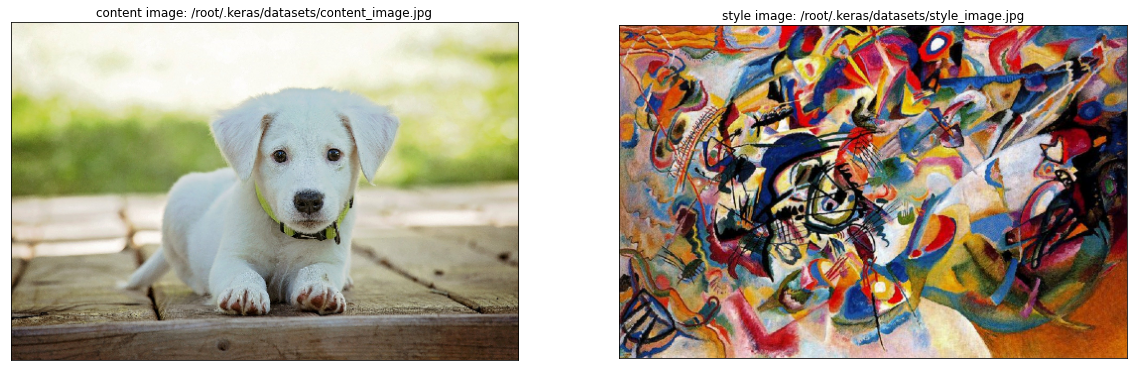

In [4]:
# display the content and style image
content_image, style_image = load_images(content_path, style_path)
show_images_with_objects([content_image, style_image],
                         titles=[f"content image: {content_path}",
                                 f"style image: {style_path}"])

## Build the Feature Extractor

In [5]:
# clear session to make layer naming consistent when re-running this cell
K.clear_session()

# download Inception model to inspect its layers
tmp_inception = tf.keras.applications.InceptionV3()
tmp_inception.summary()

del tmp_inception

96124928/96112376 [==============================] - 0s 0us/step
Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 299, 299, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 149, 149, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 149, 149, 32  96         ['conv2d[0][0]']                 
 alization)           

We will choose 89th conv layer to extract content and firs conv layers for style extraction

In [6]:
content_layers = ["conv2d_88"]

style_layers = ["conv2d", "conv2d_1", "conv2d_2", "conv2d_3", "conv2d_4"]

content_and_style_layers = style_layers + content_layers

# keep the number of style and content layers in variables
NUM_CONTENT_LAYERS = len(content_layers)
NUM_STYLE_LAYERS = len(style_layers)

## Set up the model with proper outputs

In [7]:
def inception_model(layer_names):
  """ Creates a inception model that returns a list of intermediate output values.
    args:
    layer_names: a list of strings, representing the names of the desired content and style layers
    
  returns:
    A model that takes the regular inception v3 input and outputs just the content and style layers.
  
  """
  # download the model
  inception = tf.keras.applications.InceptionV3(include_top=False, weights='imagenet')

  # freeze model's layers
  inception.trainable = False

  # list of layers' outputs from layer names
  outputs = [inception.get_layer(layer).output for layer in layer_names]

  # create a model
  model = tf.keras.Model(inputs=inception.input, outputs=outputs)

  return model

In [8]:
K.clear_session()

inception = inception_model(content_and_style_layers)

87924736/87910968 [==============================] - 0s 0us/step


## Calculate Loss

### Calculate style loss

In [9]:
def get_style_loss(features, targets):
  """Expects two images of dimension h, w, c
  
  Args:
    features: tensor with shape: (height, width, channels)
    targets: tensor with shape: (height, width, channels)

  Returns:
    style loss (scalar)
  """

  style_loss = tf.reduce_mean(tf.square(features - targets))

  return style_loss

### Calculate content loss

In [29]:
def get_content_loss(features, targets):
  """Expects two images of dimension h, w, c
  
  Args:
    features: tensor with shape: (height, width, channels)
    targets: tensor with shape: (height, width, channels)
  
  Returns:
    content loss (scalar)
  """
  content_loss = 0.5 * tf.reduce_sum(tf.square(features - targets))

  return content_loss

### Gram matrix

In [11]:
def gram_matrix(input_tensor):
  """ Calculates the gram matrix and divides by the number of locations
  Args:
    input_tensor: tensor of shape (batch, height, width, channels)
    
  Returns:
    scaled_gram: gram matrix divided by the number of locations
  """

  # calculate the gram matrix of the input tensor
  gram = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor) 

  # get the height and width of the input tensor
  input_shape = tf.shape(input_tensor) 
  height = input_shape[1] 
  width = input_shape[2] 

  # get the number of locations (height times width), and cast it as a tf.float32
  num_locations = tf.cast(height * width, tf.float32)

  # scale the gram matrix by dividing by the number of locations
  scaled_gram = gram / num_locations
    
  return scaled_gram

### Get Style image features

In [22]:
def get_style_image_features(image):  
  """ Get the style image features
  
  Args:
    image: an input image
    
  Returns:
    gram_style_features: the style features as gram matrices
  """
  
  # preprocess the input image
  preprocessed_style_image = preprocess_image(image)

  # model's outputs from the image
  outputs = inception(preprocessed_style_image)

  # retrieve only style outputs
  style_outputs = outputs[:NUM_STYLE_LAYERS]

  # calculate gram matrix for every style layer
  gram_style_features = [gram_matrix(style_layer) for style_layer in style_outputs]

  return gram_style_features

### Get Content image features

In [21]:
def get_content_image_features(image):
  """ Get the content image features
  
  Args:
    image: an input image
    
  Returns:
    content_outputs: the content features of the image
  """

  # preprocess the input image
  preprocessed_content_image = preprocess_image(image)

  # get outputs from inception model
  outputs = inception(preprocessed_content_image)

  # get only content output from a whole output list
  content_outputs = outputs[NUM_STYLE_LAYERS:]

  return content_outputs

### Calculate Total Loss

In [27]:
def get_style_content_loss(style_targets, style_outputs, content_targets, 
                           content_outputs, style_weight, content_weight):
  """ Combine the style and content loss
  
  Args:
    style_targets: style features of the style image
    style_outputs: style features of the generated image
    content_targets: content features of the content image
    content_outputs: content features of the generated image
    style_weight: weight given to the style loss
    content_weight: weight given to the content loss

  Returns:
    total_loss: the combined style and content loss

  """
  
  # Sum of the style losses
  style_loss = tf.add_n([ get_style_loss(style_output, style_target)
                           for style_output, style_target in zip(style_outputs, style_targets)])
  
  # Sum up the content losses
  content_loss = tf.add_n([get_content_loss(content_output, content_target)
                           for content_output, content_target in zip(content_outputs, content_targets)])
  
  # scale style loss
  style_loss = style_loss * style_weight / NUM_STYLE_LAYERS

  # scale content loss
  content_loss = content_loss * content_weight / NUM_CONTENT_LAYERS

  # total loss
  total_loss = style_loss + content_loss

  return total_loss

## Calculate Gradients

In [15]:
def calculate_gradients(image, style_targets, content_targets, 
                        style_weight, content_weight):
  """ Calculate the gradients of the loss with respect to the generated image
  Args:
    image: generated image
    style_targets: style features of the style image
    content_targets: content features of the content image
    style_weight: weight given to the style loss
    content_weight: weight given to the content loss
  
  Returns:
    gradients: gradients of the loss with respect to the input image
  """

  with tf.GradientTape() as tape:

    # get style image features
    style_features = get_style_image_features(image)

    # get content image features
    content_features = get_content_image_features(image)

    # get style and content loss
    loss = get_style_content_loss(style_targets, style_features, content_targets, 
                                  content_features, style_weight, content_weight)
    
  # calculate gradients of loss wrt the image
  gradients = tape.gradient(loss, image)

  return gradients

## Update image with the style

In [16]:
def update_image_with_style(image, style_targets, content_targets, style_weight, 
                            content_weight, optimizer):
  """
  Args:
    image: generated image
    style_targets: style features of the style image
    content_targets: content features of the content image
    style_weight: weight given to the style loss
    content_weight: weight given to the content loss
    optimizer: optimizer for updating the input image
  """

  # calculate gradients
  gradients = calculate_gradients(image, 
                                  style_targets, content_targets, 
                                  style_weight, content_weight)
  
  # apply gradients to the image
  optimizer.apply_gradients([(gradients, image)])

  # clip the image
  image.assign(clip_image_values(image, min_value=0.0, max_value=255.0))

## Generate Stylized image

In [24]:
def fit_style_transfer(style_image, content_image, style_weight=1e-2, content_weight=1e-4,
                       optimizer='adam', epochs=1, steps_per_epoch=1):
  """ Performs neural style transfer.
  Args:
    style_image: image to get style features from
    content_image: image to stylize 
    style_targets: style features of the style image
    content_targets: content features of the content image
    style_weight: weight given to the style loss
    content_weight: weight given to the content loss
    optimizer: optimizer for updating the input image
    epochs: number of epochs
    steps_per_epoch = steps per epoch
  
  Returns:
    generated_image: generated image at final epoch
    images: collection of generated images per epoch  
  """

  images = []
  step = 0

  # get the style image features
  style_targets = get_style_image_features(style_image)

  # get the content image features
  content_targets = get_content_image_features(content_image)

  # initialize generated image for updates
  generated_image = tf.cast(content_image, dtype=tf.float32)
  generated_image = tf.Variable(generated_image)

  images.append(content_image)

  for n in range(epochs):
    for m in range(steps_per_epoch):
      step += 1

      # Update the image with the style
      update_image_with_style(generated_image, 
                              style_targets, content_targets, 
                              style_weight, content_weight, 
                              optimizer)
      print(".", end='')

      if (m + 1) % 10 == 0:
        images.append(generated_image)
    
    # display current stylized image
    clear_output(wait=True)
    display_image = tensor_to_image(generated_image)
    display_fn(display_image)

    # append current stylized image
    images.append(generated_image)
    print("Train step: {}".format(step))

  # convert to uint8 (expected dtype for images with pixels in the range [0,255])
  generated_image = tf.cast(generated_image, dtype=tf.uint8)

  return generated_image, images

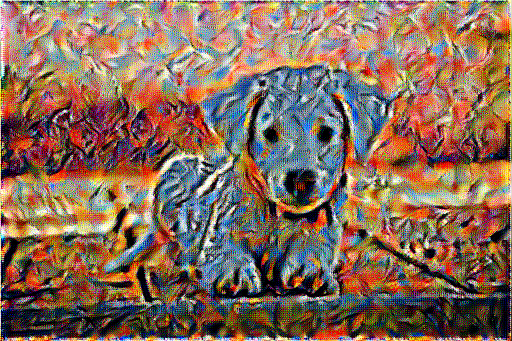

Train step: 1000


In [30]:
# define style and content weight
style_weight =  1
content_weight = 1e-32 

# define optimizer. learning rate decreases per epoch.
adam = tf.optimizers.Adam(
    tf.keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate=80.0, decay_steps=100, decay_rate=0.80
    )
)

# start the neural style transfer
stylized_image, display_images = fit_style_transfer(style_image=style_image, content_image=content_image, 
                                                    style_weight=style_weight, content_weight=content_weight,
                                                    optimizer=adam, epochs=10, steps_per_epoch=100)

In [34]:
from PIL import Image

image_array = np.squeeze(stylized_image.numpy(), axis=0)
image = Image.fromarray(image_array)
image.save('doggo.png', format="PNG")